In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial

# **Problem 1** #

## 1. ##
Proteins labelled with Cy5 -> Cy5 has excitation peak at ~ 649 nm, and emission peak at ~ 667 nm.

DNA labelled with Cy3 -> Cy3 has excitation peak at ~ 554 nm, and emission peak at ~ 566 nm.

<img src="setup.png" alt="setup" style="width:450px;"/> From "Fluorescence Correlation Spectroscopy
An Introduction to its Concepts and Applications", Petra Schwille and Elke Haustein

**Sample:**
A dilute solution (nanomolar range) containing the two species is prepared on a coverslip or within a sealed chamber. The low concentration is crucial for ensuring that only a few molecules reside in the focal volume at any given time.

**Objective:**
The objective lens focuses the beams to a small region and collects light emitted from this region. The objective lens must have a high numerical aperture (ideally NA > 0.9) in order to focus the laser light to a sufficiently small focal volume to ensure the number of simultaneously detected particles is not too large. Water immersion objectives are often used.

**Lasers:**
Either a single dual-channel laser, or 2 lasers, with wavelengths around the excitation peaks of the fluorophores (649 nm, 554 nm) will be used to excite the sample. The rest of the setup will assume the use of 2 lasers. Depending on the diameter and quality of the laser beams, beam expanders may be used to increase beam diameter so that the back aperture of the objective is more completely filled, resulting in a smaller focal volume.

**Dichroic mirrors:**
A dichroic mirror that reflects the 649 nm beam and transmits the 554 nm beam will be used to combine the two beams, before reflecting off a second dichroic mirror that reflects the excitation beams but transmits the emission wavelengths. This dichroic mirror will direct the beams toward the back aperture of the objective. After excitation and emission has occured, after the emission beams have passed through the second dichroic mirror, a final dichroic mirror is used that transmits the 566nm beam but reflects the 667 nm beam. This splits the 2 emission beams which are later collected and processed.

**Emission filters:**
Emission filters are used to selectively transmit the emitted light from the fluorophores to increase the signal to noise ratio. There will be one emission filter before the collection lens for the isolated 566 nm beam and one before the collection lens for the isolated 667 nm beam.

**Detectors + Lenses:**
The collection lenses focus the emission beams onto detectors. Pinholes are placed on the conjugate image plane (the focal point of the collection lenses corresponding to the location of the focal volume) to provide axial resolution by blocking unfocused light form below or on top of the focal volume. The detectors must be incredibly sensitive, usually an avalanche photodiode or a photomultiplier with single photon sensitivity.

## 2. ##
The emission filters should have transmission wavlengths ~ 566 nm for the Cy3 emission beam, and ~ 667 nm for the Cy5 emission beam. These values are chosen because the purpose of the emission filters is to reduce the amount of photons hitting the detector that do not originate from the fluorophores. By selectively transmitting the emission wavelenth we can increase the signal to noise ratio by removing other sources of light from the sample.

## 3. ##
$$ D = \frac{k_b  T}{6 \pi \eta r}, \quad T \approx 293.15 [K], \quad \eta_{\text{water}} \approx 1E-3 [Pa \cdot s] \text{ from Wikipedia}$$
$$ \therefore r_{protein} = 3 [nm] \implies D_{protein} = 7.15E-11 [m^2 / s], \quad r_{DNA} = 200 [nm] \implies D_{DNA} = 1.07E-12 [m^2 / s]$$

## 4. ##
We require that only a few molecules be simultaneously detected in the focal volume. The focal volume typically is ~ 1 femtoliter = 1E-15 L. We can conclude that the average number of molecules in the focal volume will simply be (concentration) * (focal volume). To ensure the signal to noise ratio is sufficiently large and that fluctutaitons of the number of particles in the detection volume is also large enough to measure, we will choose the concentration such that on average 10 particles will be in the focal volume. Since the number of particles in the volume is governed by a Poisson distribution, where the variance is equal to the mean, the relative fluctutation of particles is given by: $\sigma_{rel} = \frac{\sqrt{\mu}}{\mu} = \frac{1}{\sqrt{10}} = 0.316$ which I will assume satisfys these conditions (based on Petra Schwille's and Elke Haustein's article).
$$C \cdot V_{f} = 10, \quad V_f = 1E-15 [L] \implies C = 1E16 [ptcls / L] = 1.66E-8 [M]$$

## 5. ##
<img src="intensity.jpg" alt="intensity" style="width:700px;"/>

The proteins have a higher diffusion constant due to their lower size, thus they will diffuse across the focal volume faster, leading to shorter and more frequent fluctutations in intensity. Conversely, the lower diffusion constant of the DNA lead to slower diffusion across the focal volume and less fluctuation events.

## 6. ##
<img src="autocorrelation.jpg" alt="autocorrelation" style="width:700px;"/>

The autocorrelation function $G(\tau)$ quantifies the correlation between fluorescence intensity fluctuations at time $t$ and at a later time $t+\tau$. It is normalized by the square of the mean fluorescence intensity to account for overall signal levels. This function describes how much information from an initial fluctuation remains in the signal at a later time, reflecting the persistence of fluorescence intensity variations due to molecular motion and diffusion. The protein's autocorrelation function decays faster because the probability the protein is still inside the focal volume after time $\tau$ decreases faster due its faster diffusion. The DNA's autocorrelation function decays slower because of the slower diffusion of the larger molecule. The value $G(0) = \frac{1}{\langle N\rangle}$, (where $\langle N\rangle$ is the avg. number of particles in the focal volume) is the autocorrelation with no time delay (when the functions are perfectly correlated) and represents the fraction of the signal that a single fluctuation tends to dominate. It also provides information on the mean local concentration of molecules.

# **Problem 2** #

In [9]:
# --- simulation parameters ---
N_p = 150
L = 1500
N_kicks = np.int32(1E5)
kick_mean = 0
kick_std = np.sqrt(60)


# --- initialize particle positions ---
f = np.random.randint(0, L, N_p, dtype=np.int32)
f = np.tile(f, (N_kicks+1, 1))


# --- simulate particle motion ---
# generate random kicks
kicks = np.random.normal(loc=kick_mean, scale=kick_std, size=(N_kicks, N_p)).astype(np.int32)
# cumulatively sum kicks to get distance from original position
dist = np.cumsum(kicks, axis=0)
# add distance to particle positions
f[1:, :] += dist
# wrap around particles that have left the ring
f = f % L

# --- create intensity array ---
pre_intensity = np.zeros((N_kicks + 1, L), dtype=np.int32)
for i in range(N_kicks + 1):
    pre_intensity[i] = np.bincount(f[i], minlength=L)

## a) ##

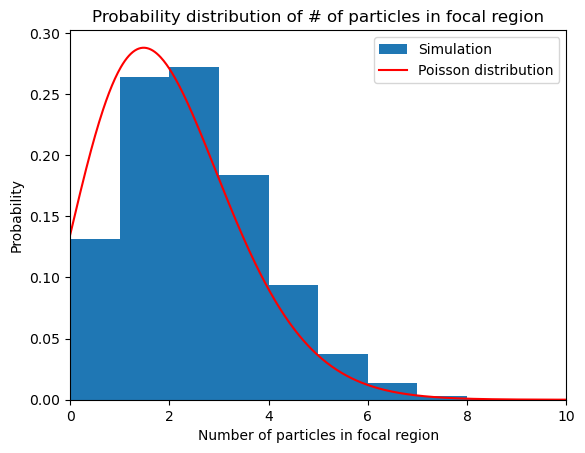

The average number of particles in the focal region is expected to be 2.0


In [10]:
window_min = int(L / 2 - 10)
window_max = int(L / 2 + 10)
mean_ptcls = 150 / L * 20

def poisson(k, mean):
    return mean**k * np.exp(-mean) / factorial(k)

p_space = np.linspace(0, 20, 1000)

focal_ptcls = pre_intensity[:, window_min:window_max].sum(axis=1)
plt.hist(focal_ptcls, bins=11, density=True, label='Simulation')
plt.plot(p_space, poisson(p_space, mean_ptcls), color='red', label='Poisson distribution')
plt.xlabel('Number of particles in focal region')
plt.ylabel('Probability')
plt.title('Probability distribution of # of particles in focal region')
plt.xlim(0, 10)
plt.legend()
plt.show()

print('The average number of particles in the focal region is expected to be {}'.format(mean_ptcls))

## b) ##

<img src="Page1.png" style="width:1000px;"/>
<img src="Page2.png" style="width:1000px;"/>
<img src="Page3.png" style="width:1000px;"/>

## c) ##

<img src="Page4.jpg" style="width:800px;"/>

## d) ##

In [39]:
L = 1500
center = int(L / 2)
x_0 = 15

# define window function
def W(x, x_0, mean):
    return np.exp(-2 * (x - mean) ** 2 / x_0 ** 2)

# apply window function to intensity array
I_arr = pre_intensity.astype(np.float64)
W_arr =  W(np.arange(L), x_0, center)
I_arr *= W_arr

# calculate total intensity
I = np.sum(I_arr, axis=1)

In [65]:
def G(T, N_kicks, I):
    return 1 / (N_kicks - T) * np.sum((I[: -T] - np.mean(I)) * (I[T:] - np.mean(I)) / (np.mean(I) ** 2))

def simulate(L, N_p, N_kicks, kick_mean, kick_std, x_0, center, tau_range):
    f = np.random.randint(0, L, N_p, dtype=np.int32)
    f = np.tile(f, (N_kicks+1, 1))

    kicks = np.random.normal(loc=kick_mean, scale=kick_std, size=(N_kicks, N_p)).astype(np.int32)
    dist = np.cumsum(kicks, axis=0)
    f[1:, :] += dist
    f = f % L

    pre_intensity = np.zeros((N_kicks + 1, L), dtype=np.int32)
    for i in range(N_kicks + 1):
        pre_intensity[i] = np.bincount(f[i], minlength=L)
    
    I_arr = pre_intensity.astype(np.float64)
    W_arr =  W(np.arange(L), x_0, center)
    I_arr *= W_arr

    I = np.sum(I_arr, axis=1)

    G_arr = np.zeros(len(tau_range), dtype=np.int32)

    for n, tau in enumerate(tau_range):
        G_val = G(tau, N_kicks, I)
        G_arr[n] = G_val

    return G_arr

sims = 10
tau_range = np.arange(1, int(1E3)).astype(np.int32)
G_arr = np.zeros(shape=(sims, max(tau_range)))

for i in range(sims):
    G_temp = simulate(L, N_p, N_kicks, kick_mean, kick_std, x_0, center, tau_range)
    G_arr[i] = G_temp

mean_G = np.mean(G_arr, axis=0)

ValueError: x and y must have same first dimension, but have shapes (999,) and (1,)

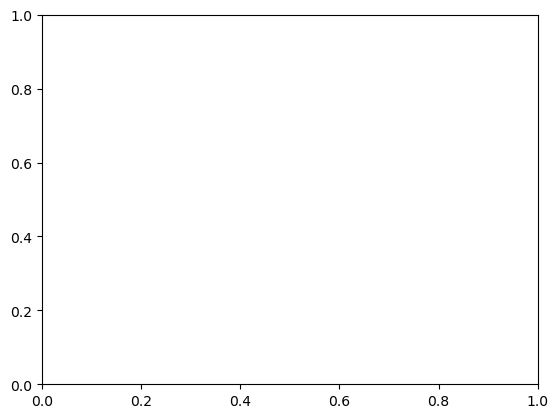

In [49]:
plt.plot(tau_range, mean_G)